## Author: Ben Dykstra



In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from __future__ import division
import seaborn as sns

%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5

In [4]:
def print_resids(preds, resids):
    ax = sns.regplot(preds, resids);
    ax.set(xlabel = 'Predicted values', ylabel = 'errors', title = 'Predicted values vs. Errors')
    plt.show();

## Problem 2

just loading the data and doing some exploration on it

In [3]:
fertility = pd.read_stata("http://rlhick.people.wm.edu/econ407/data/fertility.dta")


In [5]:
fertility.head()

,mnthborn,yearborn,age,electric,radio,tv,bicycle,educ,ceb,agefbrth,...,heduc,agesq,urban,urbeduc,spirit,protest,catholic,frsthalf,educ0,evermarr
0,5.0,64.0,24.0,1.0,1.0,1.0,1.0,12.0,0.0,NaN,...,NaN,576.0,1.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,56.0,32.0,1.0,1.0,1.0,1.0,13.0,3.0,25.0,...,12.0,1024.0,1.0,13.0,0.0,0.0,0.0,1.0,0.0,1.0
2,7.0,58.0,30.0,1.0,0.0,0.0,0.0,5.0,1.0,27.0,...,7.0,900.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0
3,11.0,45.0,42.0,1.0,0.0,1.0,0.0,4.0,3.0,17.0,...,11.0,1764.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,45.0,43.0,1.0,1.0,1.0,1.0,11.0,2.0,24.0,...,14.0,1849.0,1.0,11.0,0.0,1.0,0.0,1.0,0.0,1.0


Take a peek at the relationship between education and age of first birth, as well as the number of children and age of first birth.

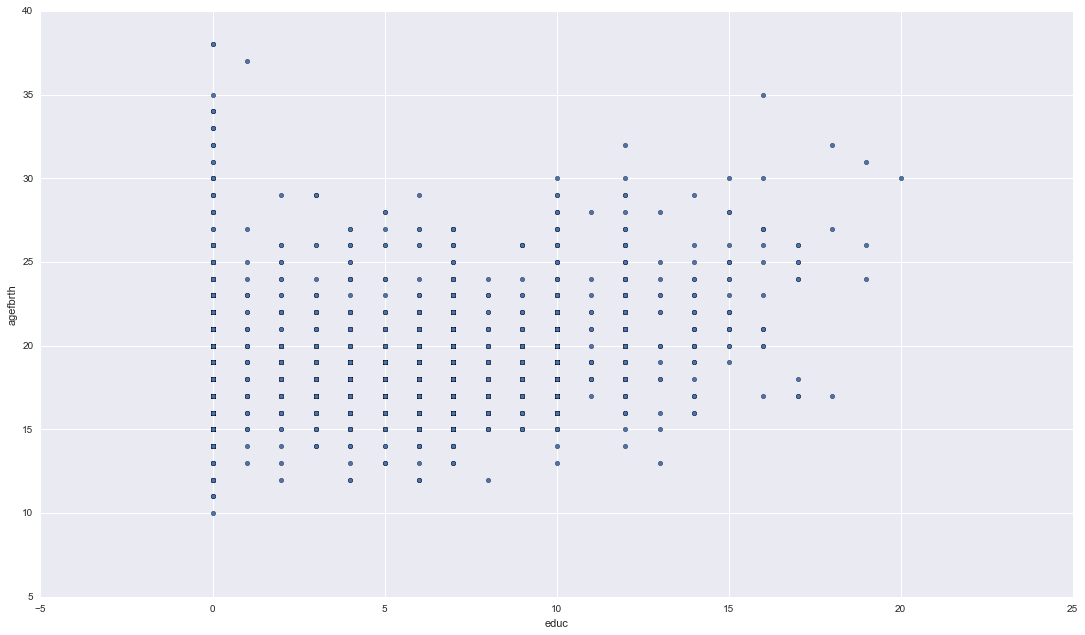

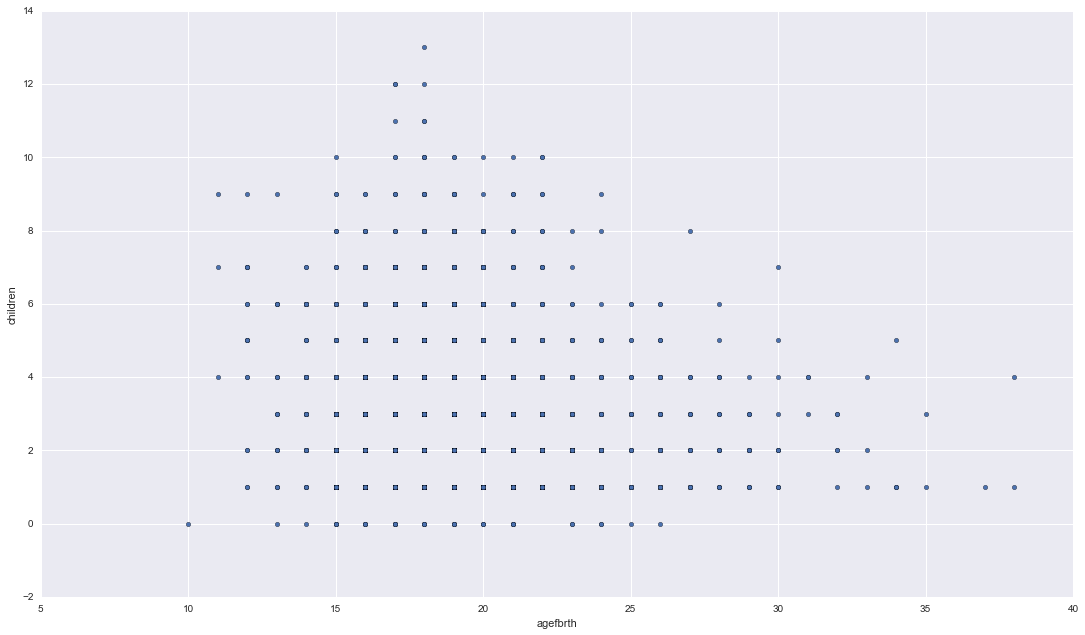

In [6]:
fertility.plot.scatter('educ', 'agefbrth'); fertility.plot.scatter( 'agefbrth', 'children');

If you squint a bit, there seems to be a small positive relationship between how much education a woman recieves and the age of her first birth. As for the relationship between age of first birth and total number of children, women who have their first child at a young age seem to have more children overall.

Lets compare the first birth age of women who use a method of contraception to those who don't.

count    2182.000000
mean       18.952795
std         2.834758
min        11.000000
25%        17.000000
50%        19.000000
75%        20.000000
max        38.000000
Name: agefbrth, dtype: float64


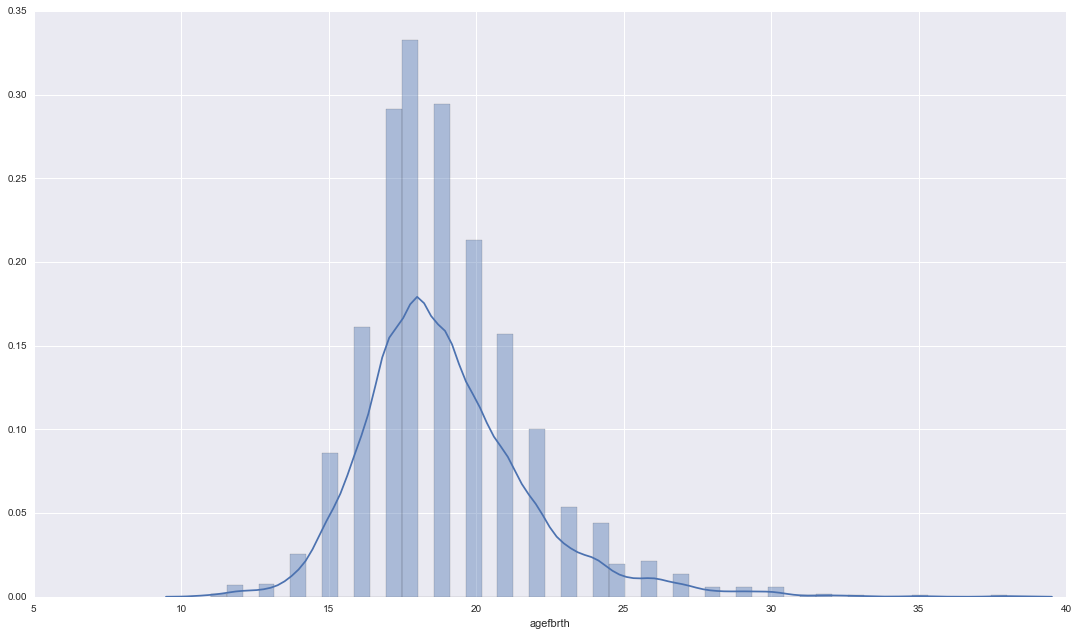

In [7]:
print fertility[fertility['usemeth'] == 1]['agefbrth'].describe()
sns.distplot(fertility[fertility['usemeth'] == 1]['agefbrth'].dropna() );

count    1031.000000
mean       19.115421
std         3.591423
min        10.000000
25%        17.000000
50%        19.000000
75%        21.000000
max        38.000000
Name: agefbrth, dtype: float64


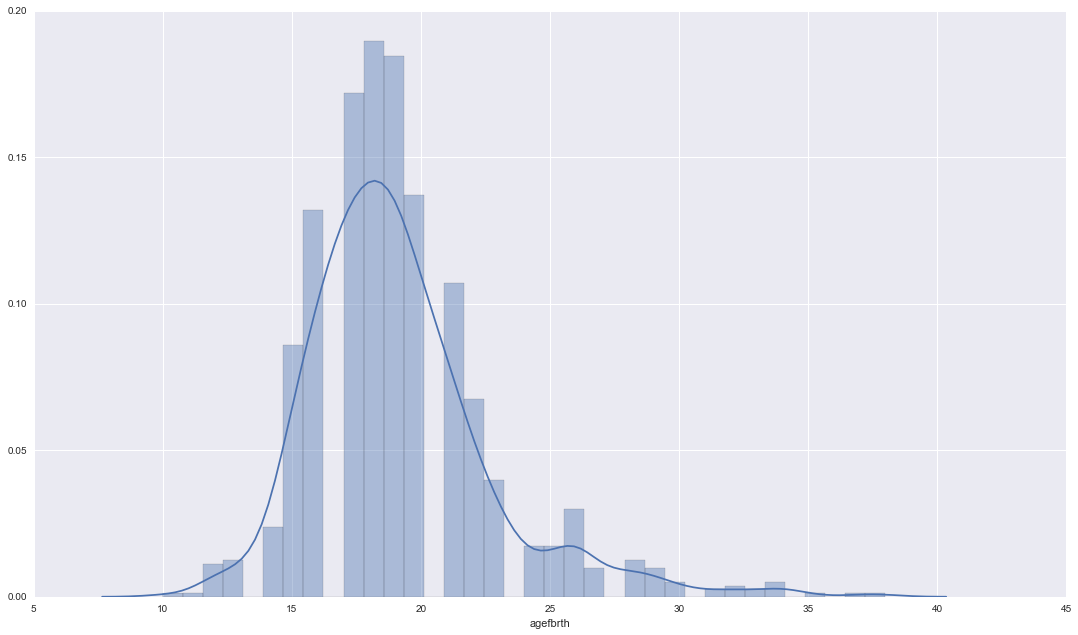

In [8]:
print fertility[fertility['usemeth'] == 0]['agefbrth'].describe()
sns.distplot(fertility[fertility['usemeth'] == 0]['agefbrth'].dropna());

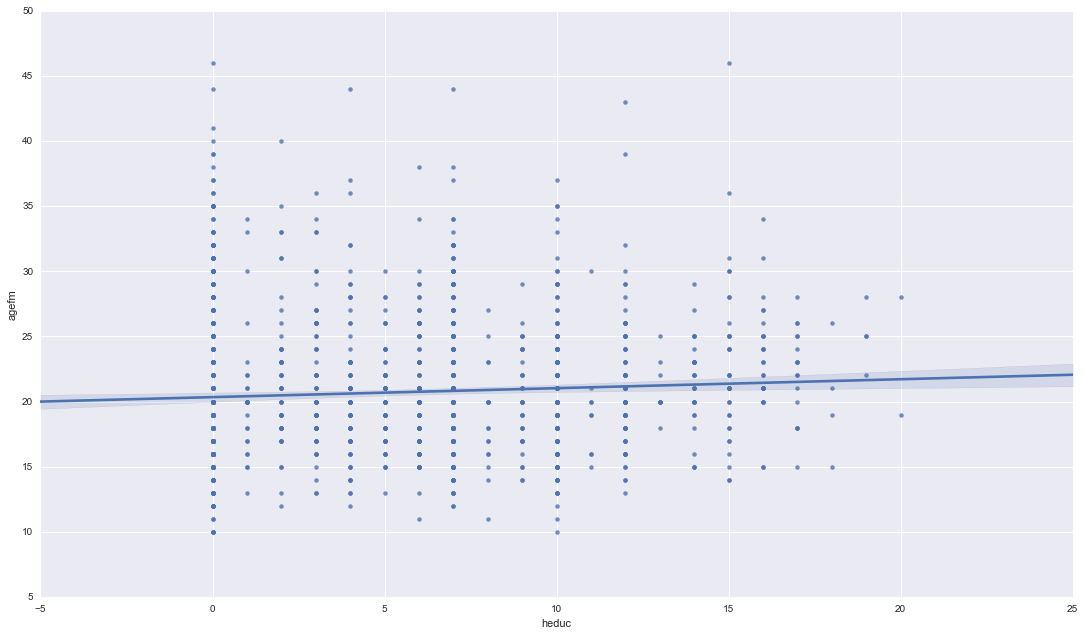

In [9]:
sns.regplot(fertility['heduc'], fertility['agefm']);

### part a

The equation I will estimate is:

$$ agefbrth = \beta_0 + \beta_1 educ + \beta_2 monthfm + \beta_3 ceb + \beta_4 idlnchld $$

We assume that there is no relationship between education and the number of children ever born or education and having month of marriage. We also assume that there is no relationship between month of first marriage and number of children born.


Theres a huge problem with missing data in this dataset, roughly a quarter of agefbrth data a missing from the total amount of observations. I get rid of the data now that has null values for age of first birth, education, month of first marriage, and children ever born.

In [10]:
#gets all columns that aren't null
no_null = fertility[(fertility['agefbrth'].notnull()) & (fertility['educ'].notnull()) & 
                    (fertility.monthfm.notnull()) & (fertility['ceb'].notnull()) & (fertility['idlnchld'].notnull())] 

print "lost {} samples of data out of a total {} samples".format(fertility.shape[0] - no_null.shape[0],
                                                                 fertility.shape[0] )

ind_vars = ['monthfm', 'ceb', 'educ', 'idlnchld']
dep_var = 'agefbrth'
x = no_null[ind_vars] 
y = no_null[dep_var]

lost 2489 samples of data out of a total 4361 samples


In [11]:
x_const = sm.add_constant(x)

first_model_results = sm.OLS(y, x_const).fit()

#results = first_model.fit()

first_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     28.83
Date:                Tue, 25 Oct 2016   Prob (F-statistic):           2.78e-23
Time:                        18:38:30   Log-Likelihood:                -4811.1
No. Observations:                1872   AIC:                             9632.
Df Residuals:                    1867   BIC:                             9660.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         18.9236      0.294     64.289      0.000        18.346    19.501
monthfm        0.0413      0.020      2.043      0.041         0.002     0.081
ceb           -0.1588      0.034     -4.640      0.000        -0.226    -0.092
educ           0.1303      0.019      6.830      0.000         0.093     0.168
idlnchld      -0.0101      0.034     -0.298      0.766        -0.077     0.056
==============================================================================
Omnibus:                      508.807   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.737
Skew:                           1.339   Prob(JB):                         0.00
Kurtosis:                       6.781   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

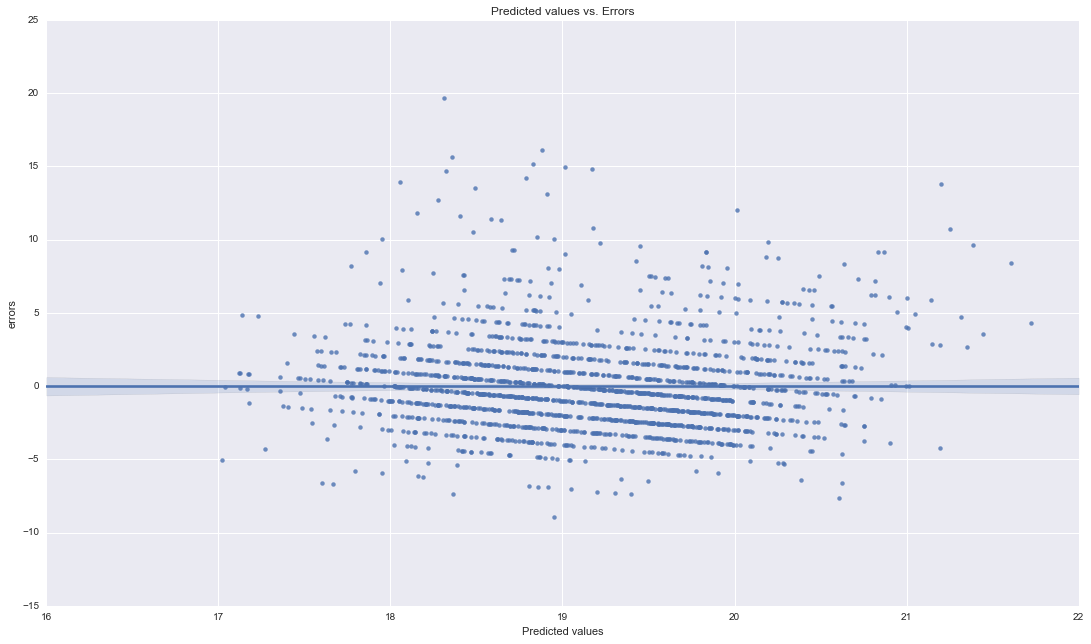

In [12]:
print_resids(first_model_results.predict(x_const), first_model_results.resid)

the descriptive statistics for the errors and a histogram of them:

count    1872.000000
mean       -0.000001
std         3.162461
min        -8.951199
25%        -2.016430
50%        -0.468158
75%         1.414013
max        19.689455
dtype: float64


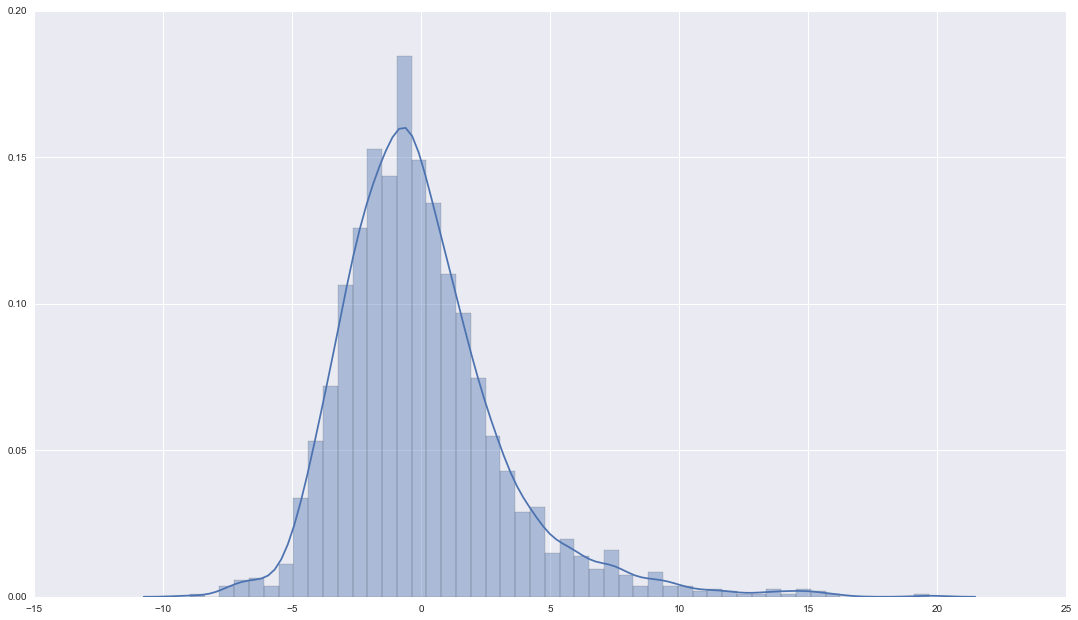

In [13]:
print "the descriptive statistics for the errors and a histogram of them:\n\n", first_model_results.resid.describe()
sns.distplot(first_model_results.resid);

There's definitely some linear structure to the errors here, however I don't know what that is caused by.  

The exogeneity assumptions are not valid here. It's reasonable to believe that amount of education recieved is correlated with errors in age of first birth. Education and the month of the first marriage are possibly *weakly* related. I'm not sure how the school years in Botswana are structured, but if a woman is in school for part of a year, she may not want to get married during any of those months, thus affecting the month she is married. We proceed with caution.

### b

I hypothesize that the most endogenous variable is education. If a child is born at a young age, there is less time for education, and it is impossible to determine which is the causal variable.

### c

I will use electricity as an instrumental variable. There is no reason to believe that errors in age of birth and electricity are directly related to each other. However, education and electricity are probably related because places that have electricity are probably more developed and thus more likely to have a school. So, electricity is related to age of first birth only via education.

### d

test for the relevancy of electricity as an instrumental variable:
    1. run relevancy equation where exogenous variables and instrument predict the endogenous variable.
    2. test whether the coefficient on the instrument is 0 via an F-test with one degree of freedom
    


In [13]:
rel = ['monthfm', 'ceb', 'electric']
endog = 'educ'

dropped_na = no_null[(no_null.monthfm.notnull()) & (no_null.ceb.notnull()) & (no_null.electric.notnull())
                    & (no_null.educ.notnull())]

only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()

relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     249.5
Date:                Thu, 06 Oct 2016   Prob (F-statistic):          7.34e-137
Time:                        10:41:10   Log-Likelihood:                -5230.6
No. Observations:                1941   AIC:                         1.047e+04
Df Residuals:                    1937   BIC:                         1.049e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.9336      0.222     26.718      0.000         5.498     6.369
monthfm        0.0255      0.022      1.137      0.256        -0.019     0.070
ceb           -0.4845      0.035    -13.826      0.000        -0.553    -0.416
electric       4.6758      0.223     20.986      0.000         4.239     5.113
==============================================================================
Omnibus:                       38.482   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.195
Skew:                           0.127   Prob(JB):                     5.57e-06
Kurtosis:                       2.515   Cond. No.                         25.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Run the hypothesis test that the coefficient on electric is 0:

[this](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.f_test.html) is where I found this test

In [14]:
hypothesis = '(electric = 0)'
print relevancy_results.f_test(hypothesis)

<F test: F=array([[ 440.41729792]]), p=2.82098141516e-88, df_denom=1937, df_num=1>


With an F-statistic of 440.417, this is surely a relevant and strong instrument.

Now lets compare the coefficient estimates from OLS to IV.

In [24]:
no_null_iv = fertility[(fertility['agefbrth'].notnull()) & (fertility['electric'].notnull()) & 
                    (fertility['monthfm'].notnull()) & (fertility['ceb'].notnull()) & (fertility['educ'].notnull())
                      & (fertility['idlnchld'].notnull())]
endog = no_null_iv['educ']
exog = no_null_iv[['monthfm', 'ceb', 'electric', 'idlnchld']]
dep_var_iv = no_null_iv['agefbrth']

exog_constant = sm.add_constant(exog)
no_endog_results = IV2SLS(endog, exog_constant, exog_constant).fit()

no_endog_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.313
Model:                         IV2SLS   Adj. R-squared:                  0.311
Method:                     Two Stage   F-statistic:                     212.0
                        Least Squares   Prob (F-statistic):          5.09e-150
Date:                Tue, 25 Oct 2016                                         
Time:                        19:07:46                                         
No. Observations:                1870                                         
Df Residuals:                    1865                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.5122      0.276     27.203      0.000         6.971     8.054
monthfm        0.0210      0.022      0.935      0.350        -0.023     0.065
ceb           -0.4053      0.037    -11.031      0.000        -0.477    -0.333
electric       4.3297      0.224     19.351      0.000         3.891     4.768
idlnchld      -0.3315      0.037     -9.004      0.000        -0.404    -0.259
==============================================================================
Omnibus:                       24.788   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.199
Skew:                           0.112   Prob(JB):                     0.000184
Kurtosis:                       2.587   Cond. No.                         35.4
==============================================================================
"""

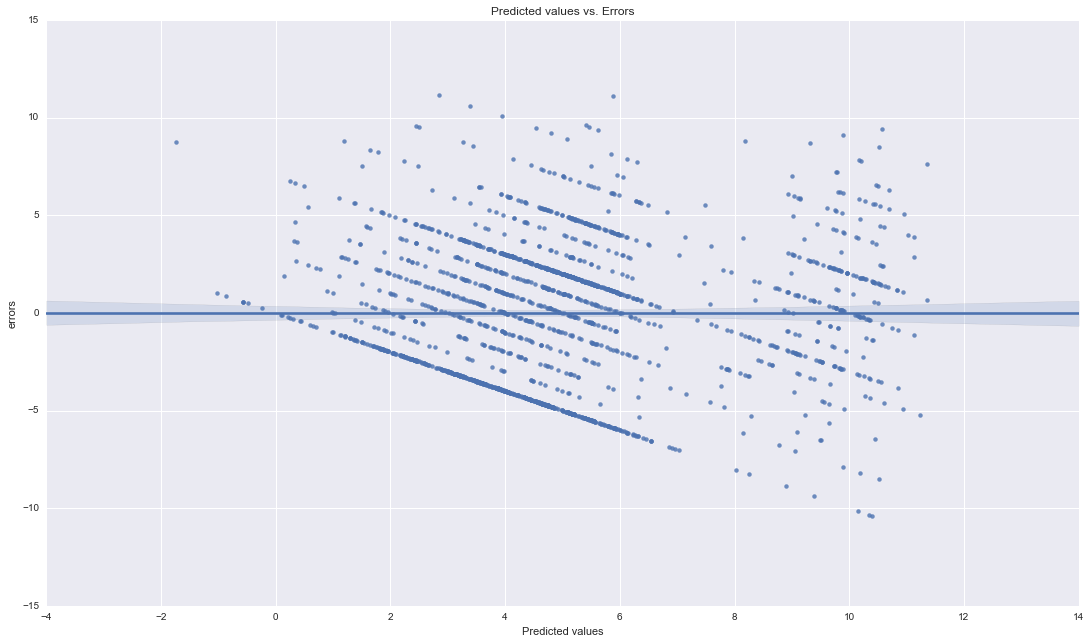

In [18]:
print_resids(no_endog_results.predict(), no_endog_results.resid)

the descriptive statistics for the errors and a histogram of them:

count    1.870000e+03
mean    -2.894172e-07
std      3.502947e+00
min     -1.038906e+01
25%     -2.920562e+00
50%      2.593660e-01
75%      2.309508e+00
max      1.114580e+01
dtype: float64


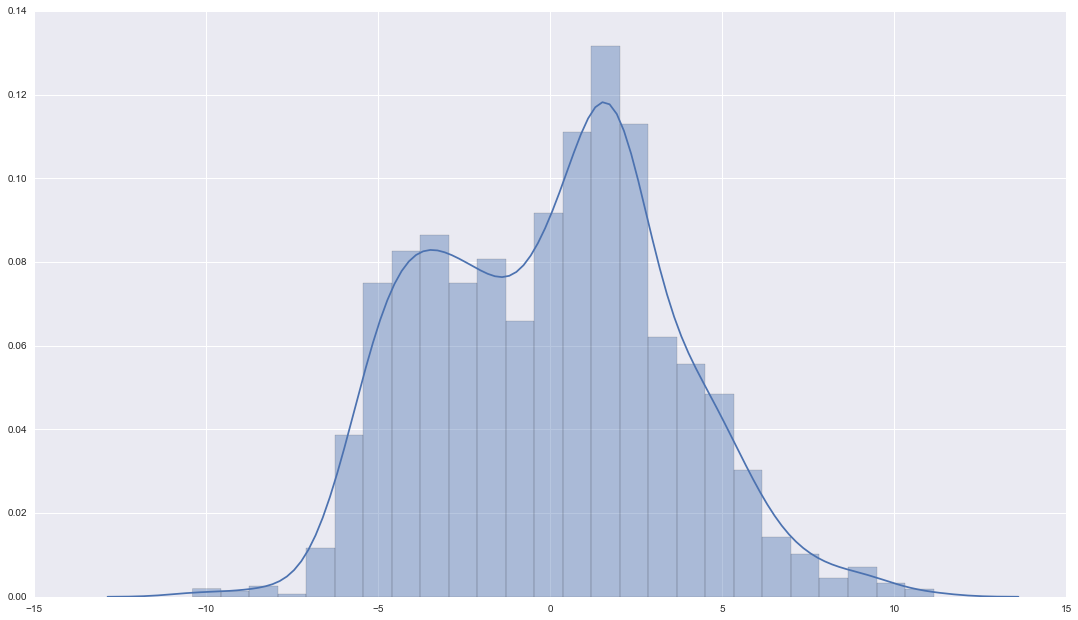

In [19]:
print "the descriptive statistics for the errors and a histogram of them:\n\n", no_endog_results.resid.describe()
sns.distplot(no_endog_results.resid);

The parameter estimates in the instrumental regression are all significantly different than the OLS regression. They are as follows:

| Variable      | OLS     | IV |
| ------------- |:-------------:| -----:|
| const      | 18.8397 | 19.3967 |
| monthfm      | 0.0430      |   0.0497 |
| ceb | -0.1541     | 0.1990    |
| educ/electric | 0.1319 | 1.4154 |

### e

replicate parts (a) and (c) using matrix algebra

first OLS estimates

In [18]:
x_mat_ols = np.matrix(x_const)
y_mat_ols = np.matrix(y)
y_mat_ols = np.reshape(y_mat_ols, (-1, 1)) #reshape so that its a single column vector, not row vector
b_ols = np.linalg.inv(x_mat_ols.T*x_mat_ols)*x_mat_ols.T*y_mat_ols
print b_ols

[[ 18.83968353]
 [  0.04297373]
 [ -0.15408325]
 [  0.13186175]]


Now the IV estimates, using the z-matrix, should be equal because I am only using 1 instrument.

In [19]:
y_iv_mat = np.matrix(y_iv)
y_iv_mat = np.reshape(y_iv_mat, (-1, 1))
z_mat = np.matrix(only_exog)
x_mat_iv = x_mat_ols[:-3] # I don't know if getting rid of those three rows is going to seriously mess things up, there
                          # are missing values....
np.linalg.inv(z_mat.T * x_mat_iv)*z_mat.T*y_iv_mat

matrix([[ 19.45337105],
        [  0.26979294],
        [ -0.78071404],
        [  0.22303759]], dtype=float32)

Yeah the missing values mess up the estimates for the iv coefficients.

### f

implementing hausman wu test

In [20]:
# add relevancy equation residuals on to the endogenous matrix
x_const['relevancy_resids'] = relevancy_results.resid
x_const = x_const.fillna(0)


In [21]:
# run endogenous regression now with residuals added in
endog_test_results = sm.OLS(y, x_const).fit()

endog_test_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     34.96
Date:                Thu, 06 Oct 2016   Prob (F-statistic):           3.17e-28
Time:                        10:41:12   Log-Likelihood:                -4974.3
No. Observations:                1944   AIC:                             9959.
Df Residuals:                    1939   BIC:                             9987.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               17.6172      0.355     49.616      0.000        16.921    18.314
monthfm              0.0413      0.020      2.111      0.035         0.003     0.080
ceb                 -0.0521      0.039     -1.326      0.185        -0.129     0.025
educ                 0.2995      0.042      7.212      0.000         0.218     0.381
relevancy_resids    -0.2059      0.046     -4.474      0.000        -0.296    -0.116
==============================================================================
Omnibus:                      512.414   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1681.998
Skew:                           1.300   Prob(JB):                         0.00
Kurtosis:                       6.742   Cond. No.                         48.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
null_hypothesis = '(relevancy_resids = 0)'
print endog_test_results.f_test(null_hypothesis)

<F test: F=array([[ 20.01885907]]), p=8.1128191509e-06, df_denom=1939, df_num=1>


We reject the null hypothesis that education is exogenous and conclude that education is indeed an endogenous variable.

The thinking behind this test is that the residuals should only include endogenous information of education because we explained all the exogenous information with monthfm and ceb. If we can then use that endogenous information to predict y in a meaningful way (i.e. the coefficient isn't zero), then that is evidence that education is correlated with age of first birth via the error term.

### g

Now we instrument for education using more than one instrumental variable. Living in an urban area should not be related to differences in the age of first birth, however, it will affect educational attainment. Again, more developed areas should (presumably) have better access to schools and education.

In [23]:
two_ivs = ['monthfm', 'ceb', 'electric', 'urban']

two_ivs_const = sm.add_constant(fertility[two_ivs])

results = sm.OLS(fertility['agefbrth'], two_ivs_const, missing = 'drop').fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     32.43
Date:                Thu, 06 Oct 2016   Prob (F-statistic):           3.39e-26
Time:                        10:41:13   Log-Likelihood:                -4972.5
No. Observations:                1941   AIC:                             9955.
Df Residuals:                    1936   BIC:                             9983.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         19.7169      0.217     90.987      0.000        19.292    20.142
monthfm        0.0482      0.020      2.450      0.014         0.010     0.087
ceb           -0.2177      0.031     -6.979      0.000        -0.279    -0.157
electric       1.6297      0.205      7.937      0.000         1.227     2.032
urban         -0.5164      0.154     -3.351      0.001        -0.819    -0.214
==============================================================================
Omnibus:                      447.712   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1286.050
Skew:                           1.183   Prob(JB):                    5.47e-280
Kurtosis:                       6.210   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

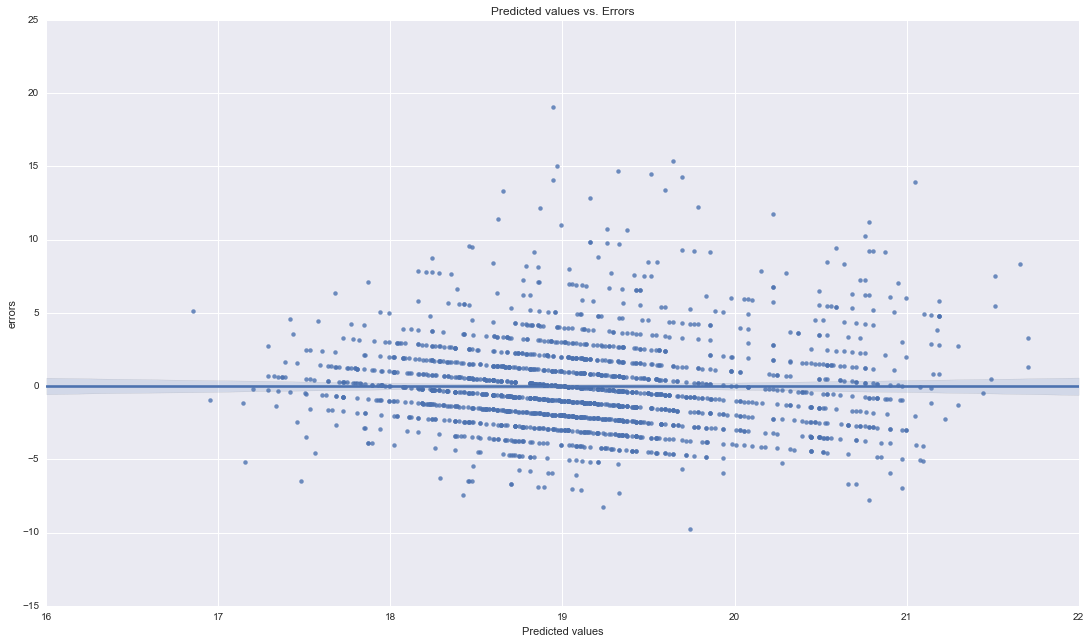

In [24]:
print_resids(results.predict(), results.resid)

count    1941.000000
mean        0.000002
std         3.136643
min        -9.740162
25%        -2.006054
50%        -0.401203
75%         1.429316
max        19.057449
dtype: float64


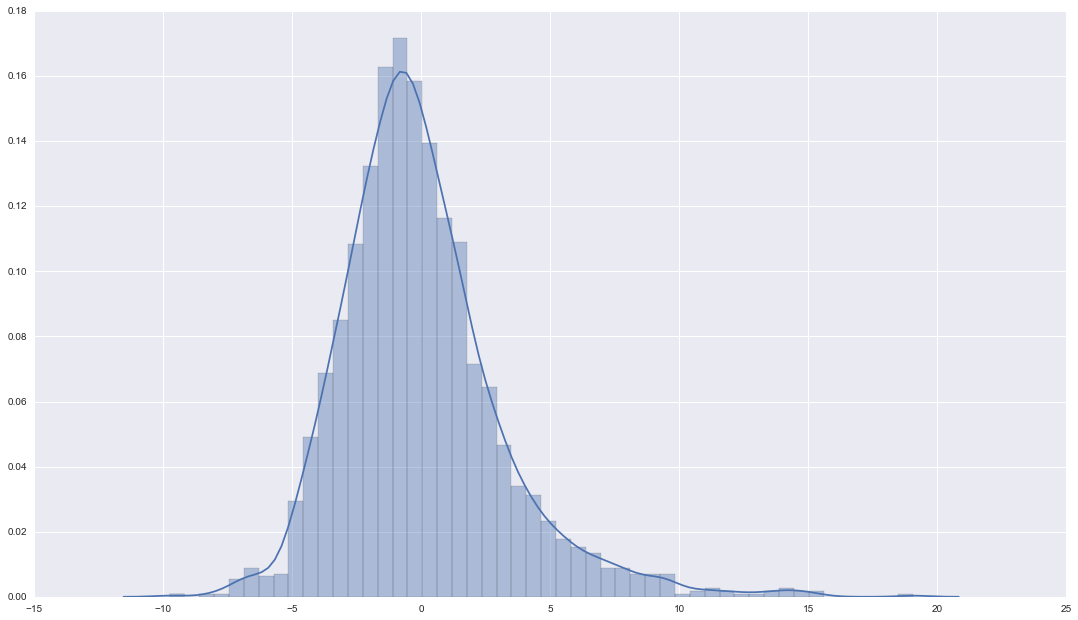

In [25]:
print results.resid.describe()
sns.distplot(results.resid);

The R^2 improves slightly with a more instrumented model. Now we test the relevancy of both of the instruments

### h

In [26]:
rel = ['monthfm', 'ceb', 'electric', 'urban']
endog = 'educ'

only_exog = sm.add_constant(fertility[rel])
relevancy_results = sm.OLS(fertility[endog], only_exog, missing = 'drop').fit()

relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     202.7
Date:                Thu, 06 Oct 2016   Prob (F-statistic):          7.76e-147
Time:                        10:41:14   Log-Likelihood:                -5587.4
No. Observations:                2076   AIC:                         1.118e+04
Df Residuals:                    2071   BIC:                         1.121e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.1261      0.228     22.450      0.000         4.678     5.574
monthfm        0.0247      0.022      1.137      0.255        -0.018     0.067
ceb           -0.4105      0.033    -12.626      0.000        -0.474    -0.347
electric       4.2665      0.225     18.979      0.000         3.826     4.707
urban          1.0167      0.169      6.019      0.000         0.685     1.348
==============================================================================
Omnibus:                       32.600   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.735
Skew:                           0.118   Prob(JB):                     1.91e-05
Kurtosis:                       2.558   Cond. No.                         25.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
null_hypotheses = '(electric = 0), (urban = 0)'
relevancy_results.f_test(null_hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 256.10277915]]), p=4.11038602441e-100, df_denom=2071, df_num=2>

I conclude that these are indeed strong and relevant instrumental variables.

### i
I cannot, for the life of me, get statsmodels to do a generalized method of moments. I'm trying to do this based off of [this](http://nbviewer.jupyter.org/gist/josef-pkt/6895915) example. I was trying to do this so that I could do Sagan's overidentification test. The statsmodels Generalized method of moments is still experimental.

In [28]:
from statsmodels.sandbox.regression.gmm import LinearIVGMM

In [29]:
hate = fertility[['agefbrth', 'monthfm', 'ceb', 'educ', 'electric', 'urban']].dropna()
hate = sm.add_constant(hate)
endog_df = hate[['monthfm', 'ceb', 'educ']]
exog_df = hate['agefbrth']
instrument_df = hate[['electric', 'urban', 'const']]

endog, exog, instrument  = map(np.asarray, [endog_df, exog_df, instrument_df])

LinearIVGMM(endog, exog, instrument).fit().summary()

IndexError: tuple index out of range

The problem of overidentification is that the instrumental variables might actually be correlated with the error. The Sagan test tests whether those errors are actually correllated with the set of supposedly exogenous instruments.

### j

The rationale for using more than one instrument is that using only one instrument might not capture all of the endogenous information in $x_k$, and adding another may help with that. We might also be able to find a more relevant set of instruments.